# Terrorismo en el mundo desde 1970 a 2017

## StoryTelling Sobre Datos de Terrorismo Global

In [37]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

StoryTelling sobre el Terrorismo en el mundo tomando como base los datos  Global Terrorism.Se aplicara un análisis exploratorio de datos, buscaremos patrones y explicaciones relacionadas con el contexto y presentaremos las conclusiones de manera dinámica y visual.

Fuente: https://start.umd.edu/gtd/




**Overview of the GTD**

Global Terrorism Database™ (GTD) es una base de datos de código abierto que incluye información sobre eventos terroristas en todo el mundo desde 1970 hasta 2019 (con actualizaciones anuales adicionales planificadas para el futuro). A diferencia de muchas otras bases de datos de eventos, GTD incluye datos sistemáticos sobre incidentes terroristas nacionales, transnacionales e internacionales que han ocurrido durante este período y ahora incluye más de 200.000 casos. Para cada incidente de GTD, la información está disponible sobre la fecha y el lugar del incidente, las armas utilizadas y la naturaleza del objetivo, el número de víctimas y, cuando sea identificable, el grupo o individuo responsable.

La información estadística contenida en la base de datos de terrorismo global se basa en informes de una variedad de fuentes de medios abiertos. La información no se agrega a la GTD a menos y hasta que hayamos determinado que las fuentes son creíbles. Los usuarios no deben inferir ninguna acción o resultado adicional más allá de lo que se presenta en una entrada de GTD y, específicamente, los usuarios no deben inferir que una persona asociada con un incidente en particular fue juzgada y condenada por terrorismo o cualquier otro delito penal. Si se dispone de nueva documentación sobre un evento, se puede modificar una entrada, según sea necesario y apropiado.

El "Consorcio Nacional para el Estudio del Terrorismo y las Respuestas al Terrorismo" (START) pone a disposición el GTD a través de esta interfaz en línea en un esfuerzo por aumentar la comprensión de la violencia terrorista para que pueda estudiarse y derrotarse más fácilmente.

Características de la GTD
Contiene información sobre más de 200.000 ataques terroristas.
Actualmente, la base de datos no clasificada más completa sobre ataques terroristas en el mundo.
Incluye información sobre más de 88.000 atentados con bomba, 19.000 asesinatos y 11.000 secuestros desde 1970
Incluye información sobre al menos 45 variables para cada caso, con incidentes más recientes que incluyen información sobre más de 120 variables
Se revisaron más de 4 000 000 artículos de noticias y 25 000 fuentes de noticias para recopilar datos de incidentes solo desde 1998 hasta 2017
Los representantes gubernamentales y los analistas interesados ​​pueden descargar los datos directamente a través de este formulario.

# Hablaremos de:

* Un panorama general del terrorismo en todo el mundo y su evolución a lo largo de los años;
* Países con más incidentes registrados;
* Países con mayor número de víctimas;
* Un tablero para el análisis del terrorismo en algunos países;
* Incidentes que duraron más de 24h (extendido = 1);
* Principales grupos radicales responsables de ataques terroristas (gname);
* Ataques con el mayor número de terroristas (nperps);
* Un WordCloud para atributos como resumen corp1, target1 y motivo;

In [38]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

import os
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime
from wordcloud import WordCloud, STOPWORDS
from branca.colormap import LinearColormap
hide_toggle()

# Funciones

In [39]:
def style_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'grey',
        'weight': 1.5,
        'dashArray': '5, 5'
    }

def highlight_function(feature):
    """
    Customize maps
    """
    return {
        'fillColor': '#ffaf00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }

def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors
    
    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """    
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    
def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    """
    This function plots data setting up frequency and percentage in a count plot;
    This also sets up borders and personalization.
    
    Input:
        The feature to be counted and the dataframe. Other args are optional.
    Returns:
        Count plot.
    """    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax, 
                           order=df[feature].value_counts().index)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax,
                           order=df[feature].value_counts().index)

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')
    ax2.set_ylabel('Frequency [%]')
    frame1 = plt.gca()
    frame1.axes.get_yaxis().set_ticks([])

    # Setting up borders
    format_spines(ax)
    format_spines(ax2)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Counting plot', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Counting plot by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
def country_analysis(country_name, data, palette, colors_plot2, color_lineplot):
    """
    This function creates a dashboard with informations of terrorism in a certain country.
    Input:
        The function receives the name of the country, the dataset and color configuration
    Output:
        It returns a 4 plot dashboard.
    """
    # Preparing
    country = data.query('country_txt == @country_name')
    if len(country) == 0:
        print('Country did not exists in dataset')
        return 
    country_cities = country.groupby(by='city', as_index=False).count().sort_values('eventid', 
                                                                                   ascending=False).iloc[:5, :2]
    suicide_size = country['suicide'].sum() / len(country)
    labels = ['Suicide', 'Not Suicide']
    colors = colors_plot2
    
    country_year = country.groupby(by='iyear', as_index=False).sum().loc[:, ['iyear', 'nkill']]
    country_weapon = country.groupby(by='weaptype1_txt', as_index=False).count().sort_values(by='eventid',
                                                                                             ascending=False).iloc[:, 
                                                                                                                   :2]
    # Dashboard
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    
    # Plot 1 - Top 5 terrorism cities
    sns.barplot(x='eventid', y='city', data=country_cities, ci=None, palette=palette, ax=axs[0, 0])
    format_spines(axs[0, 0], right_border=False)
    axs[0, 0].set_title(f'Top 5 {country_name} Ciudades con mas ocurrencias')
    """for p in axs[0, 0].patches:
        width = p.get_width()
        axs[0, 0].text(width-290, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
                ha="center", color='white')"""
    axs[0, 0].set_ylabel('City')
    axs[0, 0].set_xlabel('Victims')
    
    # Plot 2 - Suicide Rate
    center_circle = plt.Circle((0,0), 0.75, color='white')
    axs[0, 1].pie((suicide_size, 1-suicide_size), labels=labels, colors=colors_plot2, autopct='%1.1f%%')
    axs[0, 1].add_artist(center_circle)
    format_spines(axs[0, 1], right_border=False)
    axs[0, 1].set_title(f'{country_name} Tasa de Terrorismo con suicidio')
    axs[0, 0].set_ylabel('Victims')
    
    # Plot 3 - Victims through the years
    sns.lineplot(x='iyear', y='nkill', data=country_year, ax=axs[1, 0], color=color_lineplot)
    format_spines(axs[1, 0], right_border=False)
    axs[1, 0].set_xlim([1970, 2017])
    axs[1, 0].set_title(f'{country_name} Numero de Victimas en el tiempo')
    axs[1, 0].set_ylabel('Victimas')
    
    # Plot 4 - Terrorism Weapons
    sns.barplot(x='weaptype1_txt', y='eventid', data=country_weapon, ci=None, palette=palette, ax=axs[1, 1])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=90)
    axs[1, 1].set_xlabel('')
    axs[1, 1].set_ylabel('Count')
    format_spines(axs[1, 1], right_border=False)
    axs[1, 1].set_title(f'{country_name} Armas usadas en los ataques')
    
    plt.suptitle(f'Analisis de terrorismo en  {country_name} entre 1970 y 2017', size=16)    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()
hide_toggle()    

# Leyendo los datos

In [7]:
terr = pd.read_csv('globalterrorismdb_0718dist.csv', encoding='ISO-8859-1')
attribs = ['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country_txt', 'region_txt', 'city', 
                        'latitude', 'longitude', 'specificity', 'summary', 'success', 'suicide', 'attacktype1_txt', 
                        'targtype1_txt', 'corp1', 'target1', 'natlty1_txt', 'gname', 'motive', 'nperps', 
                        'weaptype1_txt', 'nkill', 'nkillter', 'nwound', 'nwoundte', 'ishostkid', 'nhostkid']
terr_data = terr.loc[:, attribs]
terr_data.head()

eventid  iyear  imonth  iday  extended         country_txt  \
0  197000000001   1970       7     2         0  Dominican Republic   
1  197000000002   1970       0     0         0              Mexico   
2  197001000001   1970       1     0         0         Philippines   
3  197001000002   1970       1     0         0              Greece   
4  197001000003   1970       1     0         0               Japan   

                    region_txt           city   latitude   longitude  ...  \
0  Central America & Caribbean  Santo Domingo  18.456792  -69.951164  ...   
1                North America    Mexico city  19.371887  -99.086624  ...   
2               Southeast Asia        Unknown  15.478598  120.599741  ...   
3               Western Europe         Athens  37.997490   23.762728  ...   
4                    East Asia        Fukouka  33.580412  130.396361  ...   

                                gname motive  nperps  weaptype1_txt nkill  \
0                              MANO-D    NaN     NaN        Unknown   1.0   
1  23rd of September Communist League    NaN     7.0        Unknown   0.0   
2                             Unknown    NaN     NaN        Unknown   1.0   
3                             Unknown    NaN     NaN     Explosives   NaN   
4                             Unknown    NaN     NaN     Incendiary   NaN   

  nkillter nwound nwoundte ishostkid nhostkid  
0      NaN    0.0      NaN       0.0      NaN  
1      NaN    0.0      NaN       1.0      1.0  
2      NaN    0.0      NaN       0.0      NaN  
3      NaN    NaN      NaN       0.0      NaN  
4      NaN    NaN      NaN       0.0      NaN  

[5 rows x 29 columns]

In [8]:
DESCRIBIR LAS COLUMNAS UTILIZADAS

SyntaxError: invalid syntax (3790401109.py, line 1)

In [9]:
terr_data['country_txt'] = terr_data['country_txt'].apply(lambda x: x.replace('United States', 
                                                                              'United States of America'))
terr_data['weaptype1_txt'] = terr_data['weaptype1_txt'].apply(lambda x: x.split()[0] if 'Vehicle' in x.split() else x)

# Terrorismo en el mundo

In [55]:
nkill_data = terr_data.groupby(by=['country_txt'], 
                                 as_index=False).sum().sort_values(by='nkill', 
                                                                   ascending=False).loc[:, ['country_txt', 'nkill']]

In [53]:
gname_data = terr_data.groupby(by=['gname'], 
                                 as_index=False).sum().sort_values(by='nkill', 
                                                                   ascending=False).loc[:, ['gname', 'nkill']]

In [56]:
#Principales grupos terroristas segun cantidad de Victimas
gname_data.head(25)

gname     nkill
3408                                            Unknown  112367.0
1535        Islamic State of Iraq and the Levant (ISIL)   38923.0
3138                                            Taliban   29410.0
704                                          Boko Haram   20328.0
2948                                  Shining Path (SL)   11601.0
1864            Liberation Tigers of Tamil Eelam (LTTE)   10989.0
177                                          Al-Shabaab    9330.0
1120   Farabundo Marti National Liberation Front (FMLN)    8065.0
2276                  Nicaraguan Democratic Force (FDN)    6662.0
3165                    Tehrik-i-Taliban Pakistan (TTP)    6042.0
2717      Revolutionary Armed Forces of Colombia (FARC)    5661.0
1800                     Kurdistan Workers' Party (PKK)    4955.0
2266                            New People's Army (NPA)    4386.0
165                                    Al-Qaida in Iraq    4381.0
1402                                    Hutu extremists    4102.0
161                                            Al-Qaida    3860.0
169            Al-Qaida in the Arabian Peninsula (AQAP)    3565.0
1891                       Lord's Resistance Army (LRA)    3123.0
1241                                  Fulani extremists    3083.0
1394                    Houthi extremists (Ansar Allah)    3050.0
160                                     Al-Nusrah Front    2978.0
2960                                    Sikh Extremists    2813.0
2239  National Union for the Total Independence of A...    2726.0
2101      Mozambique National Resistance Movement (MNR)    2559.0
888      Communist Party of India - Maoist (CPI-Maoist)    2344.0

In [41]:
nkill_data

country_txt    nkill
84               Iraq  78589.0
134          Pakistan  23822.0
0         Afghanistan  39384.0
80              India  19341.0
35           Colombia  14698.0
..                ...      ...
57   Falkland Islands      0.0
193      Vatican City      0.0
126      New Hebrides      0.0
3             Andorra      0.0
163     South Vietnam     81.0

[205 rows x 2 columns]

In [40]:
max(nkill_data.nkill) #corrresponde a Iraq

78589.0

In [ ]:
Iraq el Pais con Mayor cantidad de victimas

## A continuacion Mapa de calor  con cantidad de eventos: 

El mapa de calor nos permite detectar las zonas con mas eventos.

In [12]:
heat_data = terr_data.groupby(by=['latitude', 'longitude'], 
                                 as_index=False).count().sort_values(by='eventid', ascending=False).iloc[:, :3]

m = folium.Map(
    location=[33.312805, 44.361488], 
    zoom_start=2.5, 
    tiles='Stamen Toner'
)

HeatMap(
    name='Mapa de Calor',
    data=heat_data,
    radius=10,
    max_zoom=13
).add_to(m)

Fullscreen(
    position='topright',
    title='Expand me',
    title_cancel='Exit me',
    force_separate_button=True
).add_to(m)

m.save('terrorism_density.html')
m

El siguiente Mapa es dinamico en el tiempo, podemos ver año a año donde estan los puntos mas calientes relacionados al terrorismo.

In [13]:
year_list = []
for year in terr_data['iyear'].sort_values().unique():
    data = terr_data.query('iyear == @year')
    data = data.groupby(by=['latitude', 'longitude'], 
                        as_index=False).count().sort_values(by='eventid', ascending=False).iloc[:, :3]
    year_list.append(data.values.tolist())

m = folium.Map(
    location=[0, 0], 
    zoom_start=2.0, 
    tiles='Stamen Toner'
)

HeatMapWithTime(
    name='Terrorism Heatmap',
    data=year_list,
    radius=9,
    index=list(terr_data['iyear'].sort_values().unique())
).add_to(m)

m


Movemos la barra, podemos pensar que otros eventos sucedieron en cada uno de esos anos en las regiones 

Heat Map para 2017, ultimos datos del data set

In [14]:
month_index = [
    'jan/2017',
    'feb/2017',
    'mar/2017',
    'apr/2017',
    'may/2017',
    'jun/2017',
    'jul/2017',
    'aug/2017',
    'sep/2017',
    'oct/2017',
    'nov/2017',
    'dec/2017'
]

month_list = []
for month in terr_data.query('iyear==2017')['imonth'].sort_values().unique():
    data = terr_data.query('imonth == @month')
    data = data.groupby(by=['latitude', 'longitude'], 
                        as_index=False).sum().sort_values(by='imonth', 
                                                          ascending=True).loc[:, ['latitude', 
                                                                                   'longitude', 
                                                                                   'nkill']]
    month_list.append(data.values.tolist())

m = folium.Map(
    location=[0, 0], 
    zoom_start=1.5, 
    tiles='Stamen Toner'
)

HeatMapWithTime(
    name='Mapa de Calor',
    data=month_list,
    radius=4,
    index=month_index
).add_to(m)

m

# Paises y Terrorismo

TErrorismo por pais 

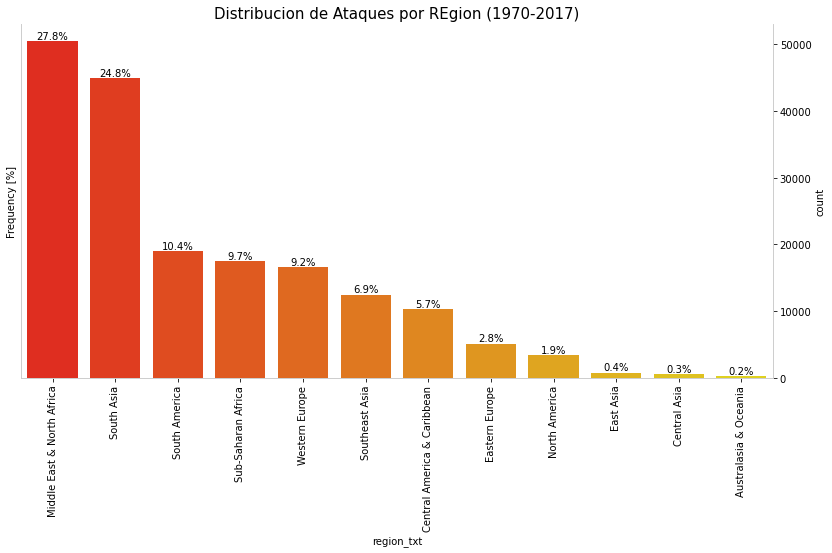

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))
count_plot('region_txt', terr_data, ax=ax, colors='autumn')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribucion de Ataques por REgion (1970-2017)', size=15)
plt.show()

La major concentracion de ataques esta en  Middle East & North Africa. Representa el  27.8% de todos los casos 1970 y 2017. 

A continuacion miraremos los 10 paises con mas incidents y compararemos data historica con data de 2017.

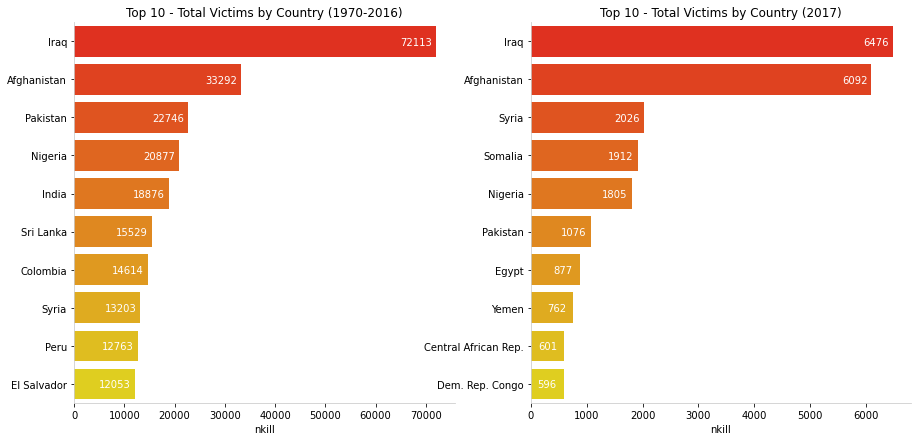

In [43]:
terr_data_no_2017 = terr_data.query('iyear != 2017')

country_victims = terr_data_no_2017.groupby(by='country_txt', as_index=False).sum().sort_values(by='nkill', 
                                                                      ascending=False).loc[:, ['country_txt', 
                                                                                               'nkill']]
country_victims = country_victims.iloc[:10, :]

terr_data_2017 = terr_data.query('iyear == 2017')
country_victims_2017 = terr_data_2017.groupby(by='country_txt', as_index=False).sum().sort_values(by='nkill', 
                                                                      ascending=False).loc[:, ['country_txt', 
                                                                                               'nkill']]
country_victims_2017 = country_victims_2017.iloc[:10, :]
country_victims_2017['country_txt'][16] = 'Central African Rep.'
country_victims_2017['country_txt'][22] = 'Dem. Rep. Congo'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.barplot(x='nkill', y='country_txt', data=country_victims, ci=None,
                 palette='autumn', ax=axs[0])
sns.barplot(x='nkill', y='country_txt', data=country_victims_2017, ci=None,
                 palette='autumn', ax=axs[1])

format_spines(axs[0], right_border=False)
format_spines(axs[1], right_border=False)
axs[0].set_title('Top 10 - Total Victims by Country (1970-2016)')
axs[1].set_title('Top 10 - Total Victims by Country (2017)')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

for p in axs[0].patches:
    width = p.get_width()
    axs[0].text(width-4000, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
            ha="center", color='white')

for p in axs[1].patches:
    width = p.get_width()
    axs[1].text(width-300, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
            ha="center", color='white')

plt.show()
hide_toggle()

In [ ]:
Principales grupos radicales responsables de ataques terroristas (gname);
Ataques con el mayor número de terroristas (nperps);

primeras acciones armadas del grupo de inspiración maoísta Sendero Luminoso en 1980, el cual se agravó con la aparición del Movimiento Revolucionario Túpac Amaru de inspiración guevarista en 1984

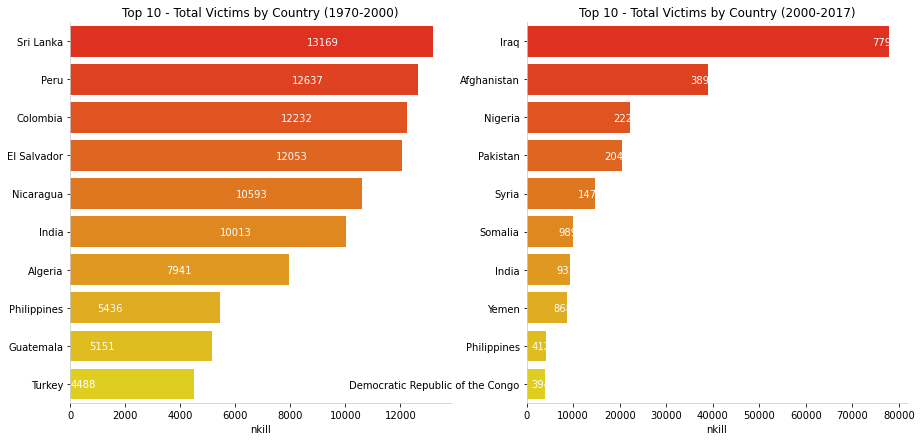

In [44]:
terr_data_no_2000 = terr_data.query('iyear <= 2000')

country_victims = terr_data_no_2000.groupby(by='country_txt', as_index=False).sum().sort_values(by='nkill', 
                                                                      ascending=False).loc[:, ['country_txt', 
                                                                                               'nkill']]
country_victims = country_victims.iloc[:10, :]

terr_data_2000 = terr_data.query('iyear > 2000')
country_victims_2000 = terr_data_2000.groupby(by='country_txt', as_index=False).sum().sort_values(by='nkill', 
                                                                      ascending=False).loc[:, ['country_txt', 
                                                                                               'nkill']]
country_victims_2000 = country_victims_2000.iloc[:10, :]
country_victims_2000['country_txt'][16] = 'Central African Rep.'
country_victims_2000['country_txt'][22] = 'Dem. Rep. Congo'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

sns.barplot(x='nkill', y='country_txt', data=country_victims, ci=None,
                 palette='autumn', ax=axs[0])
sns.barplot(x='nkill', y='country_txt', data=country_victims_2000, ci=None,
                 palette='autumn', ax=axs[1])

format_spines(axs[0], right_border=False)
format_spines(axs[1], right_border=False)
axs[0].set_title('Top 10 - Total Victims by Country (1970-2000)')
axs[1].set_title('Top 10 - Total Victims by Country (2000-2017)')
axs[0].set_ylabel('')
axs[1].set_ylabel('')

for p in axs[0].patches:
    width = p.get_width()
    axs[0].text(width-4000, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
            ha="center", color='white')

for p in axs[1].patches:
    width = p.get_width()
    axs[1].text(width-300, p.get_y() + p.get_height() / 2. + 0.10, '{}'.format(int(width)), 
            ha="center", color='white')

plt.show()
hide_toggle()

Iraq y Afganistan primeros en la lista en 2017. Colombia, Peru y El Salvador ya no estan en  2017 dejo de haber conflictos. 

A continuacion detalles de  Iraq, United States, Nigeria, Colombia y Egypt.

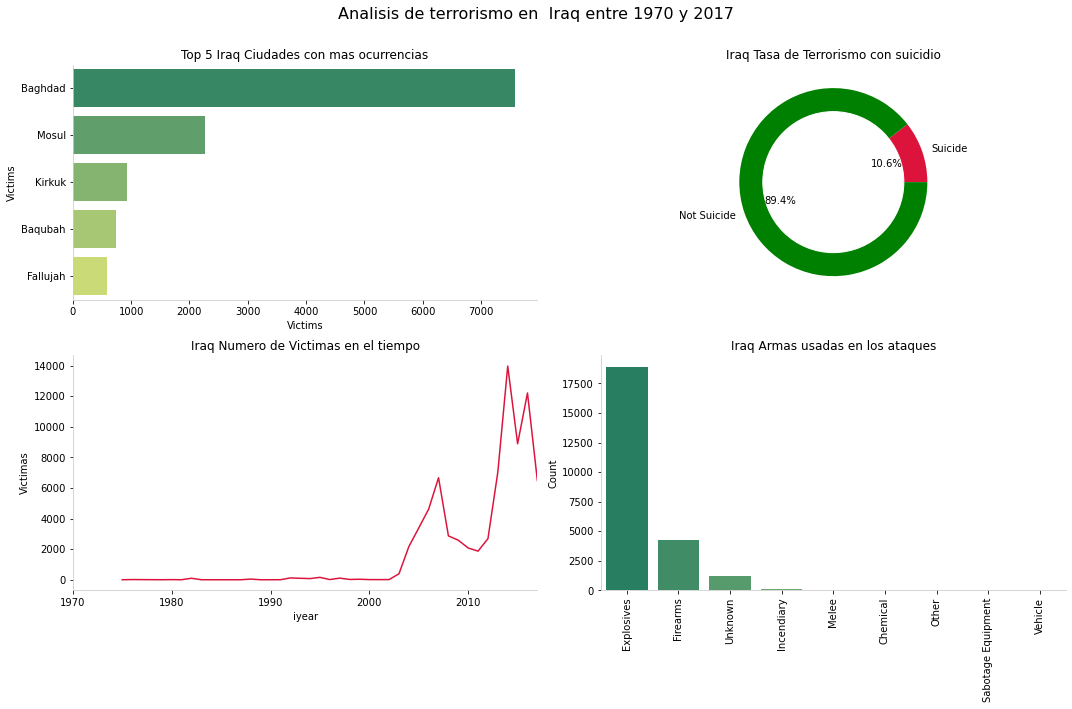

In [19]:
country_analysis(country_name='Iraq', data=terr_data, palette='summer', 
                 colors_plot2=['crimson', 'green'], color_lineplot='crimson')

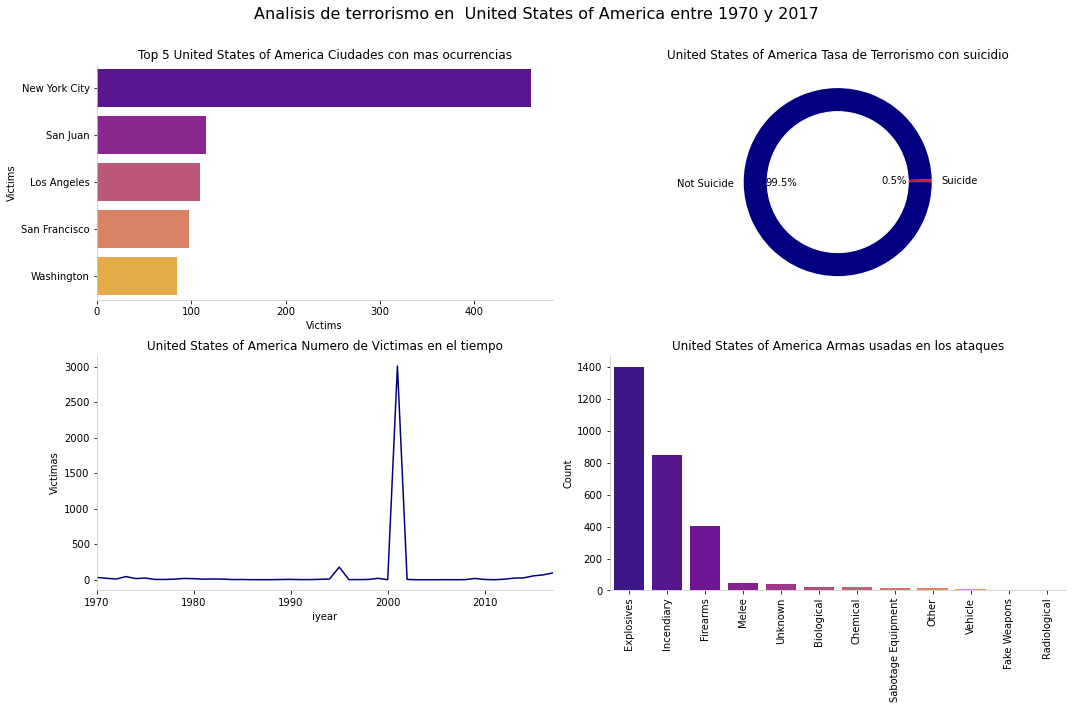

In [21]:
country_analysis(country_name='United States of America', data=terr_data, palette='plasma', 
                 colors_plot2=['crimson', 'navy'], color_lineplot='navy')

#Sobre sale 2001 evento torres gemelas

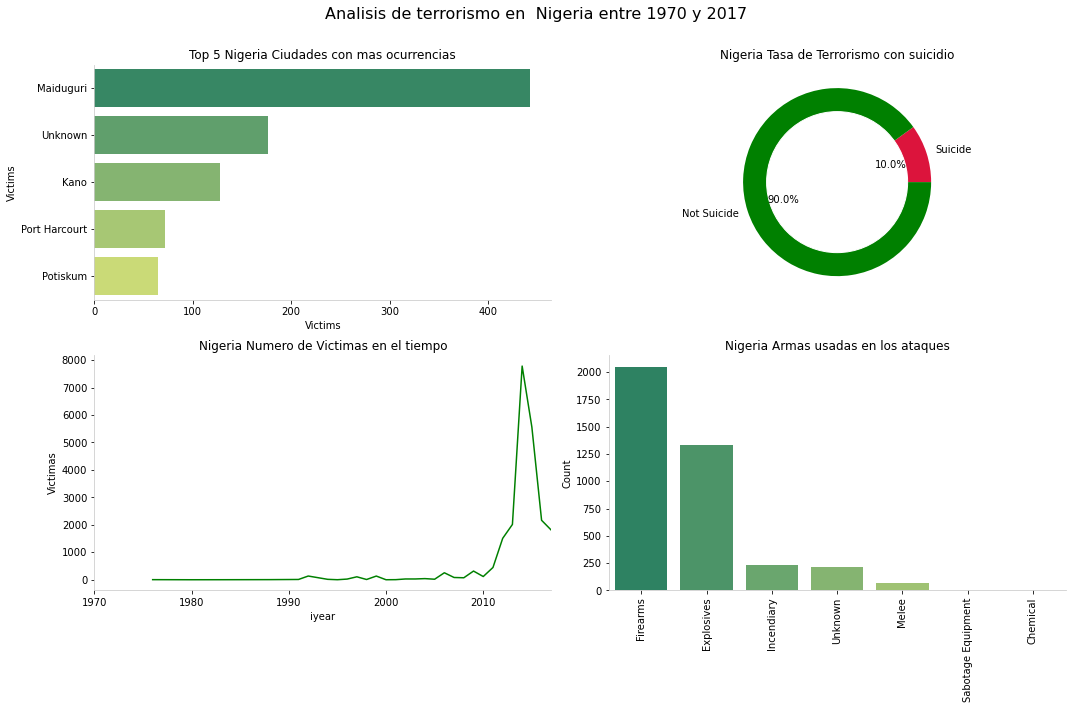

In [22]:
country_analysis(country_name='Nigeria', data=terr_data, palette='summer', 
                 colors_plot2=['crimson', 'green'], color_lineplot='green')

# Boko Haram es el nombre por el que se conoce un grupo terrorista 
#de carácter fundamentalista islámico que actúa principalmente en el norte de Nigeria. Creado en 2002, en 2015

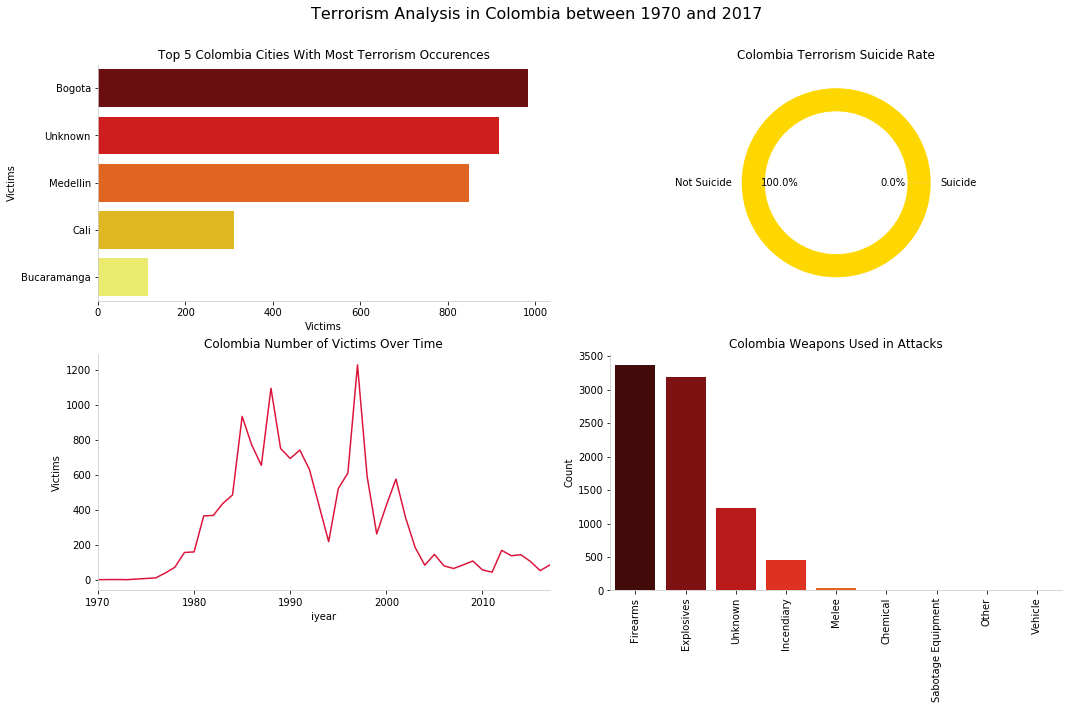

In [15]:
country_analysis(country_name='Colombia', data=terr_data, palette='hot', 
                 colors_plot2=['crimson', 'gold'], color_lineplot='crimson')

#FARCs

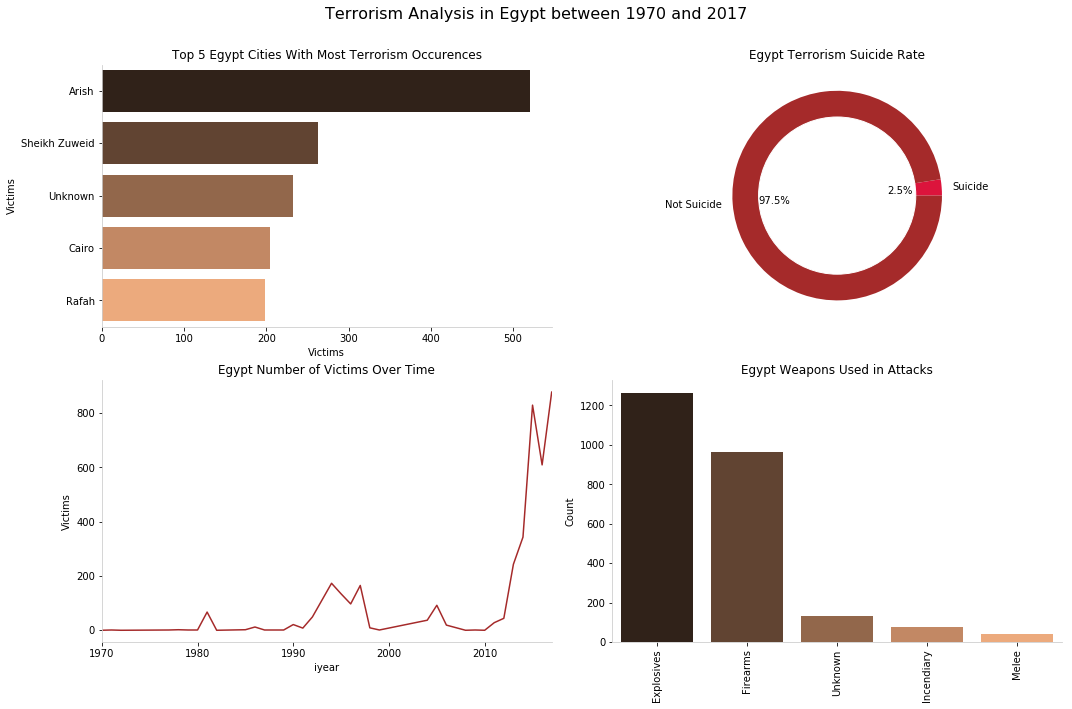

In [16]:
country_analysis(country_name='Egypt', data=terr_data, palette='copper', 
                 colors_plot2=['crimson', 'brown'], color_lineplot='brown')

#yidahismo

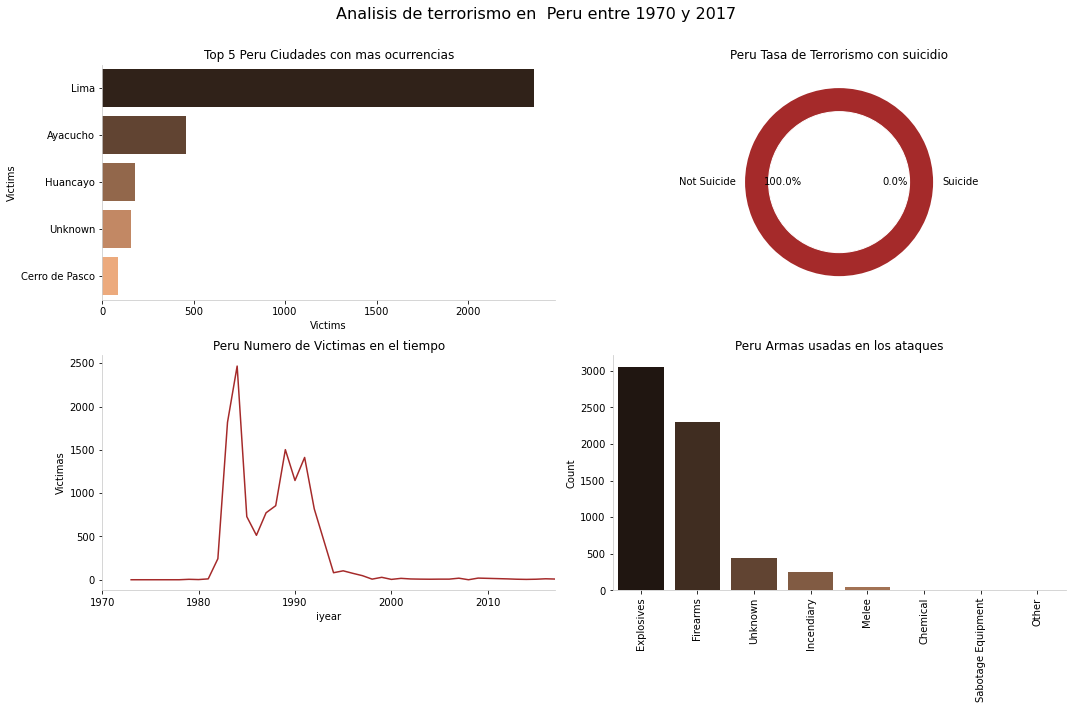

In [42]:
country_analysis(country_name='Peru', data=terr_data, palette='copper', 
                 colors_plot2=['crimson', 'brown'], color_lineplot='brown')


# NLP En el resumen del incidente

En esta seccion se aplicara algo de  Natural Language Processing para ver las palabras y entender como se describio el terrorismo alrededor del mundo. 

In [23]:
terr_data['summary'][:10]

0                                                  NaN
1                                                  NaN
2                                                  NaN
3                                                  NaN
4                                                  NaN
5    1/1/1970: Unknown African American assailants ...
6                                                  NaN
7    1/2/1970: Unknown perpetrators detonated explo...
8    1/2/1970: Karl Armstrong, a member of the New ...
9    1/3/1970: Karl Armstrong, a member of the New ...
Name: summary, dtype: object

A continuacion

* Tratar los Nan
* Y quitaremos las fechas 

In [45]:
temp_corpus = terr_data['summary'].dropna()
corpus = temp_corpus.apply(lambda x: x.split(': ')[-1]).values
print(f'Tenemos {len(corpus)} elementos en el corpus\n\n')
print(f'Ejemplo 1: \n{corpus[1]}\n')
print(f'Ejemplo 2: \n{corpus[-1]}')
hide_toggle()

Tenemos 115562 elementos en el corpus


Ejemplo 1: 
Unknown perpetrators detonated explosives at the Pacific Gas & Electric Company Edes substation in Oakland, California, United States.  Three transformers were damaged costing an estimated $20,000 to $25,000.  There were no casualties.

Ejemplo 2: 
An explosive device was discovered and defused at a plaza in Cotabato City, Maguindanao, Philippines. No group claimed responsibility for the incident.


## Expresiones Regulares

Ahora que ya hemos transformado el corpus en una estructura de matriz, apliquemos algunas expresiones regulares para tratar con elementos no deseados. El análisis que haremos en los siguientes temas abarcará:

* Búsqueda de Sitios e Hipervínculos
* Búsqueda de números
* Búsqueda de caracteres especiales
* Buscar espacios en blanco adicionales

### Sitios e hiperlinks

Para esta tarea, iteraremos por todo el corpus aplicando el método `findall` usando una expresión regular específica creada para buscar sitios e hipervínculos. Veamos qué podemos decir al respecto.

In [46]:
for c in corpus:
    urls = re.findall('(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', c)
    if len(urls) == 0:
        pass
    else:
        print(f'Descripcion: {list(corpus).index(c)} - Links: {urls}')
hide_toggle()        

Descripcion: 6977 - Links: [('http', 'www.earthliberationfront.com', '/news/2002/020116ml.html')]


1 solo poseee un hipervinculo

In [26]:
# Example
corpus[6977]

' ALF cites this incident as an anti-globalization action in their 2001 year-end Direct Action Report, available as of 13 January 2003 at http://www.earthliberationfront.com/news/2002/020116ml.html.'

lo reeemplazamos con link

In [47]:
# Replacing sites and hiperlinks
corpus_wo_hiperlinks = []
for c in corpus:
    c = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', 'link', c)
    corpus_wo_hiperlinks.append(c)
corpus_wo_hiperlinks[6977]
hide_toggle()

### Numeros

Como pudimos ver en algunos ejemplos anteriores, hay descripciones de incidentes con números. Aquí buscaremos esas descripciones de texto y reemplazaremos los números con el token 'número'.

In [28]:
# Example of description with number
corpus_wo_hiperlinks[399]

'At around 8:00 AM, a member of the Black Liberation Army flagged down a police officer driving his radio car in Manhattan, New York, United States.  When the cop pulled over, the perpetrator began stabbing the officer with a knife.  The officer then shot and killed the assailant.  That morning, the New York Times received two anonymous calls stating that a New York policeman would be killed at 8:00 AM unless the BLA received $100,000.'

In [48]:
# Replacing numbers
corpus_wo_numbers = []
for c in corpus_wo_hiperlinks:
    c = re.sub('\d+(?:\.\d*(?:[eE]\d+))?', 'number', c)
    corpus_wo_numbers.append(c)
corpus_wo_numbers[399]
hide_toggle()

### Charcteres especiales

Una vez más, siempre que estemos mirando las descripciones de los incidentes, nos enfrentamos a algunos caracteres especiales que deben reemplazarse para un análisis más detallado. Para esto, apliquemos otra expresión regular para reemplazar los caracteres especiales con espacios en blanco.

In [30]:
# Example with special characteres
corpus_wo_numbers[1113]

'Members of the Evan Mecham Eco-Terrorist International Conspiracy (EMETIC), claimed responsibility for damaging the pylons and cables which supported the main ski chairlift at the Fairfield Snow Bowl Ski Resort in Flagstaff, Arizona in the United States,   There were no casualties, but the property damage was estimated at $number,number and an additional $number,number to heighten security at the resort. In a letter to the ski resort, the group stated that "if trees were not allowed to grow back" and "ski operations not discontinued," then more damage would occur. Marc Leslie Davis, Margaret Katherine Millet, Ilse Washington Asplund, and Marc Andre Baker were arrested and in number, pled guilty and sentenced for their involvement in this incident.'

In [31]:
# Replacing special characteres with whitespace
corpus_text = []
for c in corpus_wo_numbers:
    c = re.sub(r'\W', ' ', c)
    corpus_text.append(c)
corpus_text[1113]

'Members of the Evan Mecham Eco Terrorist International Conspiracy  EMETIC   claimed responsibility for damaging the pylons and cables which supported the main ski chairlift at the Fairfield Snow Bowl Ski Resort in Flagstaff  Arizona in the United States    There were no casualties  but the property damage was estimated at  number number and an additional  number number to heighten security at the resort  In a letter to the ski resort  the group stated that  if trees were not allowed to grow back  and  ski operations not discontinued   then more damage would occur  Marc Leslie Davis  Margaret Katherine Millet  Ilse Washington Asplund  and Marc Andre Baker were arrested and in number  pled guilty and sentenced for their involvement in this incident '

### Espacios adicionales

con regex

In [32]:
# Removing additional whitespaces
corpus_after_regex = []
for c in corpus_text:
    c = re.sub(r'\s+', ' ', c)
    corpus_after_regex.append(c)
    
corpus_after_regex[1113]

'Members of the Evan Mecham Eco Terrorist International Conspiracy EMETIC claimed responsibility for damaging the pylons and cables which supported the main ski chairlift at the Fairfield Snow Bowl Ski Resort in Flagstaff Arizona in the United States There were no casualties but the property damage was estimated at number number and an additional number number to heighten security at the resort In a letter to the ski resort the group stated that if trees were not allowed to grow back and ski operations not discontinued then more damage would occur Marc Leslie Davis Margaret Katherine Millet Ilse Washington Asplund and Marc Andre Baker were arrested and in number pled guilty and sentenced for their involvement in this incident '

## Lower Case

In [33]:
cleaned_corpus = pd.Series(corpus_after_regex).apply(lambda x: x.lower())
cleaned_corpus = list(cleaned_corpus.values)
cleaned_corpus[990]

'the vietnamese organization to exterminate communists and restore the nation claimed responsibility for shooting nguyen van luy and his wife pham thi luu in front of their residence in san francisco california united states van luy a vocal defender of vietnam s communist government was wounded and thi luu was killed '

## WordCloud

Nube de palabras

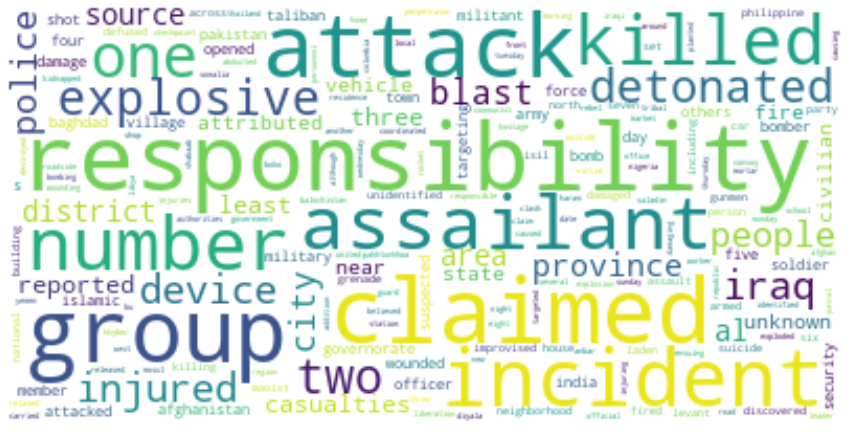

In [49]:
# Genereando wordcloud
text = ' '.join(cleaned_corpus)
stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(text)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
hide_toggle()